In [27]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd

from collections import defaultdict

In [2]:
original_data = pd.read_csv('../data/pedalboard-plugin.csv', sep=",", index_col=['id', 'name'])
original_data.head()

plugin1  plugin2  plugin3  plugin4  plugin5  plugin6
id    name                                                            
9467  !!*Cuda'         23       27       73      109      106       61
7313  '70s*V.H**       39       30      100       60      107      107
      '90s*V.H**       23       99       31       42       53       60
9467  *!!*Wanted       23       27       85       49       60      107
10849 **********      107      107      107      107      107       84

In [64]:
total = pd.DataFrame(data={
    f'plugin{i}': original_data[f'plugin{i}'].value_counts()
    for i in range(1, 7)
}).fillna(0)

total.head(5)

,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
0,4.0,3.0,5.0,0.0,1.0,0.0
1,8.0,6.0,13.0,3.0,0.0,1.0
2,3.0,12.0,3.0,0.0,1.0,0.0
3,0.0,6.0,4.0,2.0,1.0,2.0
4,0.0,4.0,1.0,7.0,13.0,0.0


In [65]:
frequencies = total / total.sum()

frequencies.head(5)

,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
0,0.002106,0.001580,0.002633,0.000000,0.000527,0.000000
1,0.004213,0.003160,0.006846,0.001580,0.000000,0.000527
2,0.001580,0.006319,0.001580,0.000000,0.000527,0.000000
3,0.000000,0.003160,0.002106,0.001053,0.000527,0.001053
4,0.000000,0.002106,0.000527,0.003686,0.006846,0.000000


# KNN

In [3]:
def distance(a, b):
    return sum([0 if a == b else 1 for (a, b) in zip(a, b)])

In [56]:
def compare(index, column, train, test, hits_by_plugin):
    equals = []
    
    for test_index, i in enumerate(index):
        train_recommendations = train.iloc[i]
        test_element = test.iloc[test_index]

        element = test_element[column]
        is_present = element in train_recommendations[column].values
        equals.append(is_present)
        
        if is_present:
            hits_by_plugin[column][element] += 1

    return np.array(equals, dtype=np.int32).sum()

In [58]:
def measure(data, k, n_splits=10):
    kfolds = KFold(n_splits=n_splits, random_state=42, shuffle=False)
    columns = [f'plugin{i}' for i in range(1, 7)]

    print(f'k={k}')
    
    hits_by_kfold = []
    z = []
    for kfold, (train_index, test_index) in enumerate(kfolds.split(data)):
        hits = pd.DataFrame(data={f'plugin{i+1}': np.zeros(117) for i in range(6)})
        hits_by_kfold.append(hits)
        
        train, test = data.iloc[train_index], data.iloc[test_index]

        nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance).fit(train)

        y = []
        for plugin in columns:
            test_plugin = test.copy()
            test_plugin[plugin] = -1

            distances, indices = nbrs.kneighbors(test_plugin)
            x = compare(indices, plugin, train, test, hits) / len(test)
            y.append(x)
            print(f'K fold={kfold}, {plugin}: {x}')

        z.append(sum(y)/6)
        print('Total:', z[-1])

    print()
    print('TOTAL:', sum(z)/n_splits)
    return sum(z)/n_splits, hits_by_kfold

In [377]:
data = shuffle(original_data, random_state=42)
evaluate_k1, hits_kfolds_k1 = measure(data, k=1, n_splits=10)
evaluate_k5, hits_kfolds_k5 = measure(data, k=5, n_splits=10)
#measure(data, k=5)

k=5
K fold=0, plugin1: 0.6368421052631579
K fold=0, plugin2: 0.3894736842105263
K fold=0, plugin3: 0.3368421052631579
K fold=0, plugin4: 0.4263157894736842
K fold=0, plugin5: 0.5736842105263158
K fold=0, plugin6: 0.6894736842105263
Total: 0.5087719298245614
K fold=1, plugin1: 0.6157894736842106
K fold=1, plugin2: 0.4105263157894737
K fold=1, plugin3: 0.4631578947368421
K fold=1, plugin4: 0.4368421052631579
K fold=1, plugin5: 0.4631578947368421
K fold=1, plugin6: 0.6684210526315789
Total: 0.5096491228070176
K fold=2, plugin1: 0.6052631578947368
K fold=2, plugin2: 0.45789473684210524
K fold=2, plugin3: 0.3631578947368421
K fold=2, plugin4: 0.4421052631578947
K fold=2, plugin5: 0.5578947368421052
K fold=2, plugin6: 0.7105263157894737
Total: 0.5228070175438596
K fold=3, plugin1: 0.5421052631578948
K fold=3, plugin2: 0.3526315789473684
K fold=3, plugin3: 0.42105263157894735
K fold=3, plugin4: 0.47368421052631576
K fold=3, plugin5: 0.5526315789473685
K fold=3, plugin6: 0.7105263157894737
Tot

# Inspect hits by plugin

In [395]:
from functools import reduce

hits_kfolds_k1_mean = reduce(lambda a, b: a+b, hits_kfolds_k1[1:], hits_kfolds_k1[0]) / len(hits_kfolds_k1)
hits_kfolds_k5_mean = reduce(lambda a, b: a+b, hits_kfolds_k5[1:], hits_kfolds_k5[0]) / len(hits_kfolds_k5)

In [438]:
plugin1 = total['plugin1'][total['plugin1'] != 0].sort_values()

def split(x, steps):
    summation = x.sum()
    
    step_size = summation/(steps*1.)
    cumsum = x.cumsum()

    k_minus_1 = [x[(step_size*i < cumsum) & (cumsum <= (step_size*(i+1)))] for i in range(steps-1)]
    k_th = [x[step_size*(steps-1) < cumsum]]

    return k_minus_1 + k_th

#x = split(plugin1, 4)
#for e in x:
#    print(e.sum())

467.0
407.0
387.0
638.0


In [418]:
def range_accuracy(column, hits, total, k=4):
    hits = hits[column]
    total = total[column]
    
    totals = []
    for part in split(total.sort_values(), k):
        totals.append(hits.iloc[part.index].sum() / part.sum())

    return pd.Series(totals, name=column)

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/ipykernel-5.1.0-py3.6.egg/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ec3278390>,
      dtype=object)

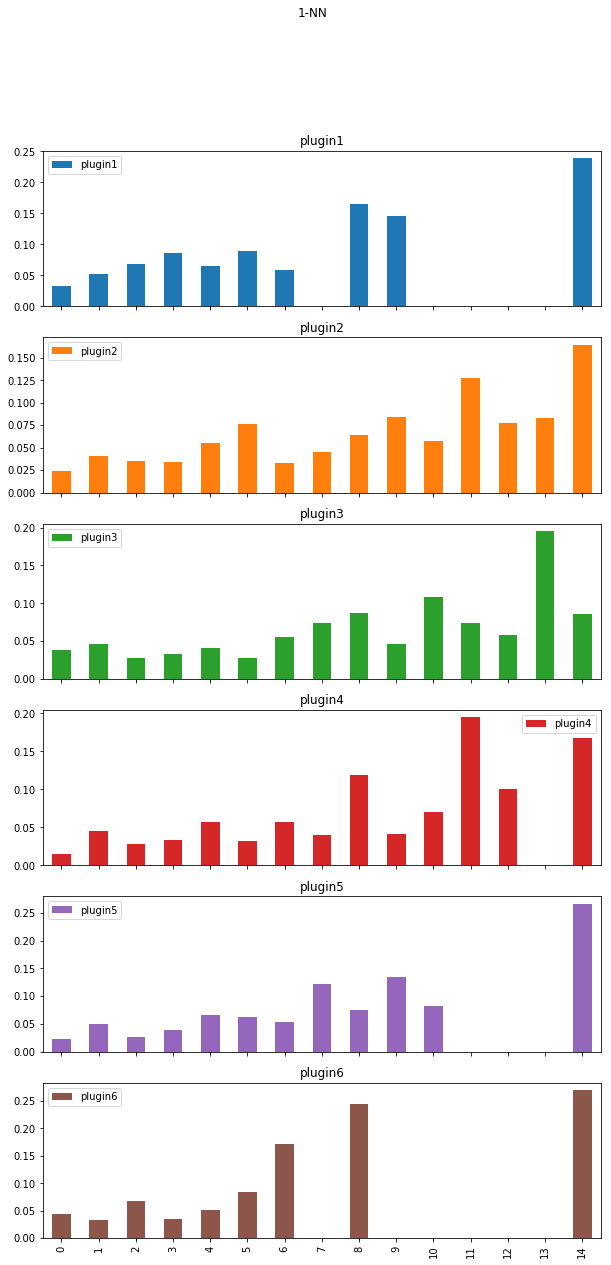

In [453]:
k1_result = pd.DataFrame({
    f'plugin{i}': range_accuracy(f'plugin{i}', hits_kfolds_k1_mean, total, k=15)
    for i in range(1, 7)
})
#k1_result.plot.bar(title="1-NN", subplots=True, figsize=(10, 20))
k1_result#.plot.bar(title="1-NN", subplots=True, figsize=(10, 20))

(k1_result/k1_result.sum()).plot.bar(title="1-NN", subplots=True, figsize=(10, 20))

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/ipykernel-5.1.0-py3.6.egg/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ec3c36eb8>,
      dtype=object)

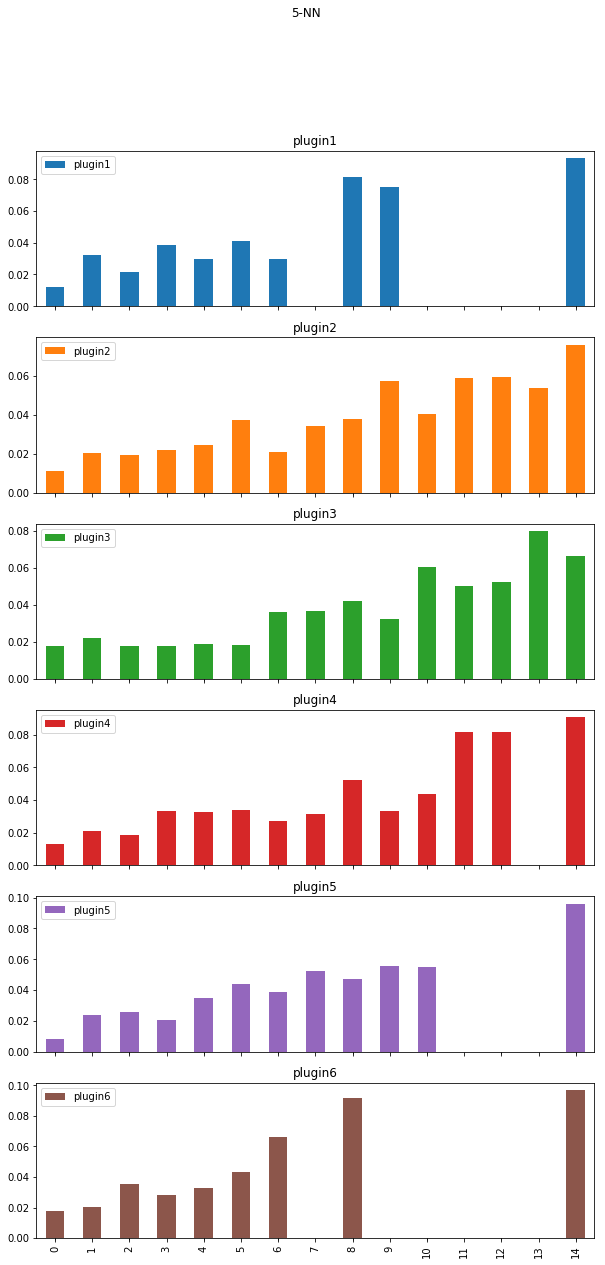

In [443]:
k5_result = pd.DataFrame({
    f'plugin{i}': range_accuracy(f'plugin{i}', hits_kfolds_k5_mean, total, k=15)
    for i in range(1, 7)
})
k5_result.plot.bar(title="5-NN", subplots=True, figsize=(10, 20))

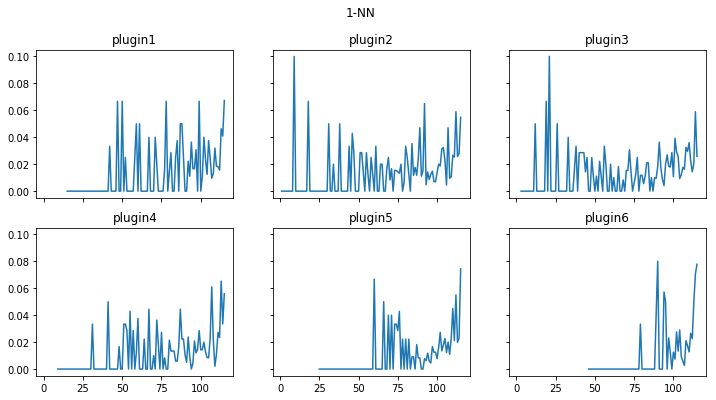

In [523]:
import matplotlib.pyplot as plt

#hits_kfolds_k5_mean['plugin1']
#range_accuracy(f'plugin{i}', hits_kfolds_k1_mean, total, k=15)

def individual_accuracy(total, evaluated, title):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
    fig.suptitle(title)
    
    #fig.set_ylabel('Undamped')

    for i, ax in zip(range(1, 7), axes.reshape(-1)):
        column = f'plugin{i}'

        #indices = total[column][total[column] != 0].sort_values().index
        indices = total[column].sort_values().index

        (evaluated[column] / total[column]).iloc[indices].to_frame().reset_index()[column].plot(title=column, ax=ax, figsize=(12, 6))


individual_accuracy(total, hits_kfolds_k1_mean, '1-NN')

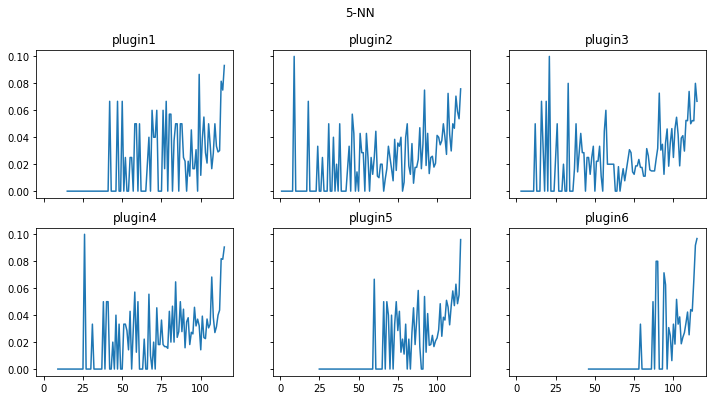

In [524]:
individual_accuracy(total, hits_kfolds_k5_mean, '5-NN')

# Quality of the recommendations by audio plugin category